In [1]:
import os
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
sys.path.append('..')

In [3]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms.functional import gaussian_blur
torch.jit.script = lambda x: x

import re 
import h5py
from glob import glob
from functools import partial
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy.spatial.distance import pdist, cdist
from scipy import stats

from hpst.trainers.heterogenous_point_set_sim_trainer import HeterogenousPointSetSimTrainer
from hpst.dataset.heterogenous_sparse_sim_dataset_2d import HeterogenousSparseDataset
from hpst.utils.options import Options


# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cmasher as cmr
import seaborn as sb

In [4]:
CUDA = True
CUDA_DEVICE = 0
USE_TEX = False
TESTING_FILE = None

# TESTING_SOURCE = "interpretation"
# GRADIENT = False

# TESTING_SOURCE = "production"
# GRADIENT = False

TESTING_SOURCE= "testing"
GRADIENT = False

NETWORK = HeterogenousPointSetSimTrainer

In [5]:
TESTING_FILE = "/home/roblesee/dune/hpst/data/sim_data/test"
BASE_DIRECTORY =  "../results/hpst/lightning_logs/version_216"
#CHECKPOINT_PATH = "../lightning_logs/version_35/checkpoints/epoch=9-step=75000.ckpt"
CHECKPOINT_PATH = "../results/hpst/lightning_logs/version_216/checkpoints/last.ckpt"

# Load checkpoint and add the test file location
options = Options.load(f"{BASE_DIRECTORY}/options.json")


if TESTING_FILE:
    options.testing_file = TESTING_FILE
else:
    options.testing_file = options.training_file.replace("training", TESTING_SOURCE)
options.num_dataloader_workers = 0

if CHECKPOINT_PATH is None:
    checkpoints = glob(f"{BASE_DIRECTORY}/checkpoints/epoch*.ckpt")
    last_checkpoint = np.argmax([int(re.search("step=(.*).ckpt", s)[1]) for s in checkpoints])
    checkpoint_path = checkpoints[last_checkpoint]
else:
    checkpoint_path = CHECKPOINT_PATH
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint["state_dict"]
print(f"Loading from: {checkpoint_path}")

network = NETWORK(options)
network.load_state_dict(state_dict)

network = network.eval()

if not GRADIENT:
    for parameter in network.parameters():
        parameter.requires_grad_(False)

if CUDA:
    network = network.cuda(CUDA_DEVICE)

/tmp/ipykernel_23185/4183236021.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


Loading from: ../results/hpst/lightning_logs/version_216/checkpoints/last.ckpt
loading training
/home/roblesee/dune/hpst/data/sim_data/train


/home/roblesee/dune/hpst/notebooks/../hpst/dataset/heterogenous_sparse_sim_dataset_2d.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache = torch.load(CACHE_FILE)


torch.Size([96121445])
tensor(0) tensor(7)
tensor([ 3934726, 32700353, 14400657,  6840341,  4122813, 16635800, 16389512,
         1097251])
/home/roblesee/dune/hpst/data/sim_data/train
torch.Size([17384720])
tensor(0) tensor(7)
tensor([ 700580, 5991115, 2512217, 1235725,  732458, 3079125, 2938741,  194767])
loading testing
/home/roblesee/dune/hpst/data/sim_data/test
torch.Size([29556102])
tensor(0) tensor(7)
tensor([ 1209661, 10009491,  4467592,  2064444,  1284430,  5145802,  5066251,
          308439])


In [6]:
DATASET = network.testing_dataset

In [7]:
DATASET.return_index = True

In [8]:
dataloader_options = network.dataloader_options
dataloader_options["pin_memory"] = False
dataloader_options["num_workers"] = 0
dataloader_options["batch_size"] = 32
dataloader_options["drop_last"] = False

test_dataloader = network.dataloader(DATASET, **dataloader_options)

In [9]:
total_coords1 = []
total_coords2 = []

total_predictions1 = []
total_predictions2 = []

total_object_predictions1 = []
total_object_predictions2 = []


total_targets1 = []
total_targets2 = []

total_object_targets1 = []
total_object_targets2 = []

total_raws1 = []
total_raws2 = []

total_batch_idx1 = []
total_batch_idx2 = []

current_batch1 = 0
current_batch2 = 0

num_objects = 10

total_ids = []
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    total_ids.append(ids)
    
    mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    mask2 = ((targets2 != -1))#(object_targets2 < num_objects))
    
    total_coords1.append(coordinates1[mask1].cpu())
    total_coords2.append(coordinates2[mask2].cpu())
    
    total_predictions1.append(predictions1[mask1].argmax(-1).cpu())
    total_predictions2.append(predictions2[mask2].argmax(-1).cpu())
    
    total_object_predictions1.append(object_predictions1[mask1].argmax(-1).cpu())
    total_object_predictions2.append(object_predictions2[mask2].argmax(-1).cpu())
    
    total_targets1.append(targets1[mask1].cpu())
    total_targets2.append(targets2[mask2].cpu())
    
    total_object_targets1.append(object_targets1[mask1].cpu())
    total_object_targets2.append(object_targets2[mask2].cpu())
    
    total_raws1.append(predictions1[mask1].cpu())
    total_raws2.append(predictions2[mask2].cpu())
    
    total_batch_idx1.append(batches1[mask1].cpu() + current_batch1 + 1)
    current_batch1 += batches1.max().item() + 1
    
    total_batch_idx2.append(batches2[mask2].cpu() + current_batch2 + 1)
    current_batch2 += batches2.max().item() + 1    
    
total_predictions1 = torch.cat(total_predictions1)
total_predictions2 = torch.cat(total_predictions2)
total_targets1 = torch.cat(total_targets1)
total_targets2 = torch.cat(total_targets2)
total_raws1 = torch.cat(total_raws1)
total_raws2 = torch.cat(total_raws2)
total_batch_idx1 = torch.cat(total_batch_idx1)
total_batch_idx2 = torch.cat(total_batch_idx2)
total_coords1 = torch.cat(total_coords1)
total_coords2 = torch.cat(total_coords2)
total_ids = torch.cat(total_ids)

100%|██████████████████████████████████████████████████████████████| 1248/1248 [03:19<00:00,  6.26it/s]


In [10]:
(
    ids,
    batches1, 
    features1, 
    coordinates1, 
    targets1,
    object_targets1,
    batches2, 
    features2,
    coordinates2,
    targets2,
    object_targets2
) = batch

predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
    features1, coordinates1, batches1, features2, coordinates2, batches2
)

In [11]:
from torch_cluster import knn_graph, knn

In [12]:
this = network.network.network.patch_embed

feat1 = torch.cat([coordinates1, features1], dim=-1)
feat2 = torch.cat([coordinates2, features2], dim=-1)

feat1 = this.proj1(feat1)
feat2 = this.proj1(feat2)

this = this.blocks.blocks[0].attn

qkv1 = this.qkv1(feat1)
qkv1 = qkv1.reshape(-1, 2*3, this.num_heads, this.embed_channels//this.num_heads) # (N', V*3*C) => (N', V*3, H, C//H)
qkv1 = qkv1.permute(1, 0, 2, 3) # (N'1, V*3, H, C//H) => (V*3, N'1, H, C//H)
query11, key11, value11, query12, key12, value12 = qkv1.unbind(dim=0)

qkv2 = this.qkv2(feat2)
qkv2 = qkv2.reshape(-1, 2*3, this.num_heads, this.embed_channels//this.num_heads) # (N', V*3*C) => (N', V*3, H, C//H)
qkv2 = qkv2.permute(1, 0, 2, 3) # (N'2, V*3, H, C//H) => (V*3, N'2, H, C//H)
query21, key21, value21, query22, key22, value22 = qkv2.unbind(dim=0)

n1 = feat1.shape[0]
n2 = feat2.shape[0]

graph1 = knn_graph(coordinates1, k=8, batch=batches1, loop=True, flow='target_to_source')
graph2 = knn_graph(coordinates2, k=8, batch=batches2, loop=True, flow='target_to_source')
graph12 = knn(coordinates1[:,[1]], coordinates2[:,[1]], k=8, batch_x=batches1, batch_y=batches2)
graph21 = knn(coordinates2[:,[1]], coordinates1[:,[1]], k=8, batch_x=batches2, batch_y=batches1)

key = key21[graph21[1],...] # # (n_neighbors*n, h, c)
query = query12[graph21[0],...] # (n_neighbors*n, h, c)
value = value21[graph21[1],...] # (n_neighbors*n, h, c)

value[graph21[0] == 0].shape

torch.Size([8, 16, 8])

In [13]:
graph12.shape[1] // 8, n2

(5394, 5394)

In [14]:
graph21.shape[1] // 8, n1

(5201, 5201)

In [15]:
coordinates2.shape

torch.Size([5394, 2])

In [16]:
graph21[1]

tensor([  33,   35,   37,  ..., 5372, 5385, 5393], device='cuda:0')

In [17]:
graph21[0][graph21[1] == 0]

tensor([2, 3, 4], device='cuda:0')

In [18]:
graph1[:,:100]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
          6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12],
        [ 0,  1,  2,  4,  3,  5,  6,  7,  1,  0,  2,  4,  3,  5,  6,  7,  2,  4,
          3,  1,  0,  5,  6,  7,  3,  2,  4,  1,  0,  5,  6,  7,  4,  2,  3,  1,
          0,  5,  6,  7,  5,  8,  6,  7,  9, 10, 11, 12,  6,  7,  9, 10, 11, 12,
         13, 14,  7,  6,  9, 10, 11, 12, 13, 14,  8,  5,  9, 10,  7, 11,  6, 12,
          9, 10, 11, 12, 13,  7, 14,  6, 10,  9, 11, 12, 13, 14,  7, 15, 11, 10,
         12,  9, 13, 14, 15, 17, 12, 11, 10, 13]], device='cuda:0')

In [19]:
batches2[:100]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], device='cuda:0')

In [20]:
graph21[0][:100]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 12, 12, 12, 12], device='cuda:0')

In [21]:
len(graph12[1].unique())

3325

In [22]:
len(graph1[1].unique())

5201

In [23]:
len(graph2[1].unique())

5394

In [24]:
graph1

tensor([[   0,    0,    0,  ..., 5200, 5200, 5200],
        [   0,    1,    2,  ..., 5194, 5195, 5192]], device='cuda:0')

In [25]:
total_object_predictions1 = torch.cat(total_object_predictions1)
total_object_predictions2 = torch.cat(total_object_predictions2)

In [26]:
total_object_targets1 = torch.cat(total_object_targets1)
total_object_targets2 = torch.cat(total_object_targets2)

In [27]:
total_targets1.shape

torch.Size([29555138])

In [28]:
total_raws1.shape

torch.Size([29555138, 8])

In [29]:
from torch_cluster import knn_graph, knn

In [30]:
total_probabilities1 = torch.softmax(total_raws1, dim=-1)
total_probabilities2 = torch.softmax(total_raws2, dim=-1)

In [31]:
total_probabilities1.shape

torch.Size([29555138, 8])

In [32]:
unique = torch.cat([total_targets1[:].unique().long(), total_targets2[:].unique().long()]).unique()

In [33]:
unique

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [34]:
tp1 = total_probabilities1[:]/total_probabilities1[:].sum(axis=1, keepdim=True)
tp2 = total_probabilities2[:]/total_probabilities2[:].sum(axis=1, keepdim=True)

In [35]:
tp1.shape, tp2.shape

(torch.Size([29555138, 8]), torch.Size([29576872, 8]))

In [36]:
tp = torch.cat([tp1, tp2], axis=0)
total_targets = torch.cat([total_targets1, total_targets2], axis=0)
total_predictions = torch.cat([total_predictions1, total_predictions2], axis=0)
total_raws = torch.cat([total_raws1, total_raws2], axis=0)
total_object_predictions = torch.cat([total_object_predictions1, total_object_predictions2], axis=0)
total_batch_idx = torch.cat([total_batch_idx1, total_batch_idx2], axis=0)

In [37]:
tp.shape, total_targets.shape

(torch.Size([59132010, 8]), torch.Size([59132010]))

In [38]:
print(f"ROC AUC: {roc_auc_score(total_targets[:], tp, multi_class='ovr', average='weighted'):.3f}")

ROC AUC: 0.936


In [39]:
CLASS_NAMES = {
    0: "other",
    1: "electron",
    2: "muon",
    3: "proton",
    4: "neutron",
    5: "charged pion",
    6: "neutral pion",
    7: "photon"
}

Text(0.5, 1.0, 'Class distribution')

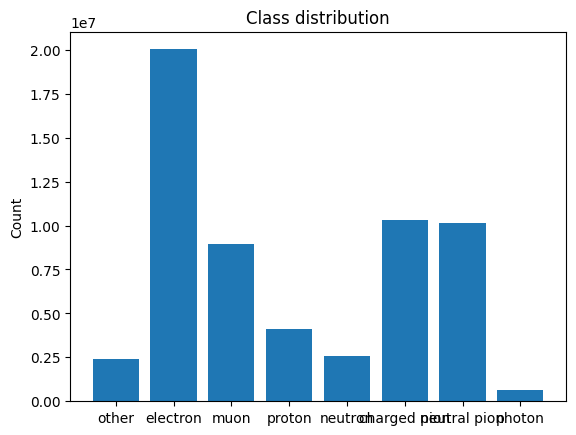

In [40]:
plt.bar(range(8), torch.bincount(total_targets).numpy())
plt.xticks(range(8), list(CLASS_NAMES.values()))
plt.ylabel("Count")
plt.title("Class distribution")

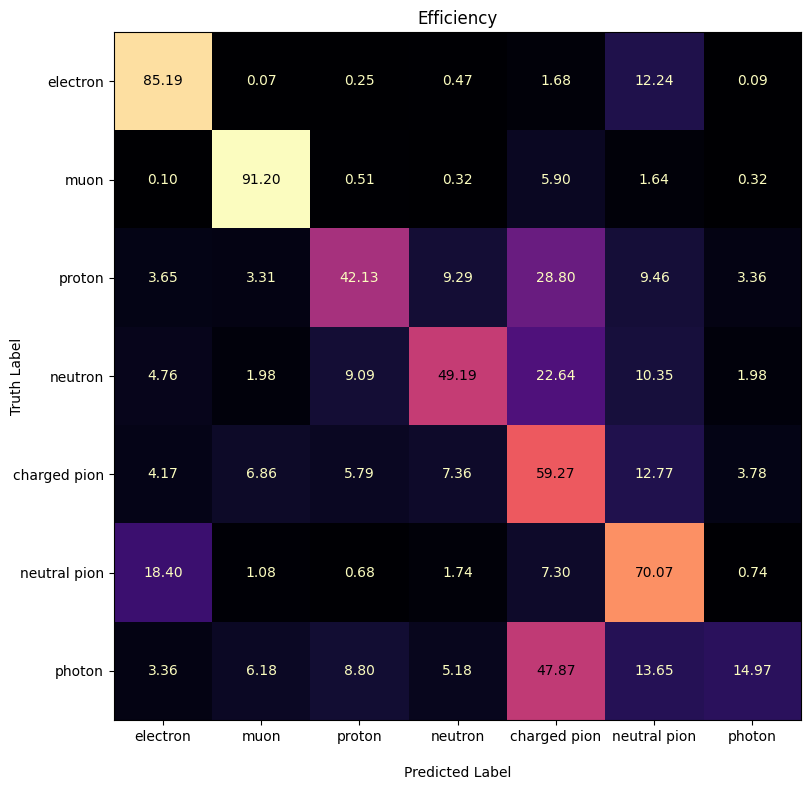

In [41]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    total_predictions.numpy(), 
    normalize='true',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Efficiency")
plt.tight_layout()

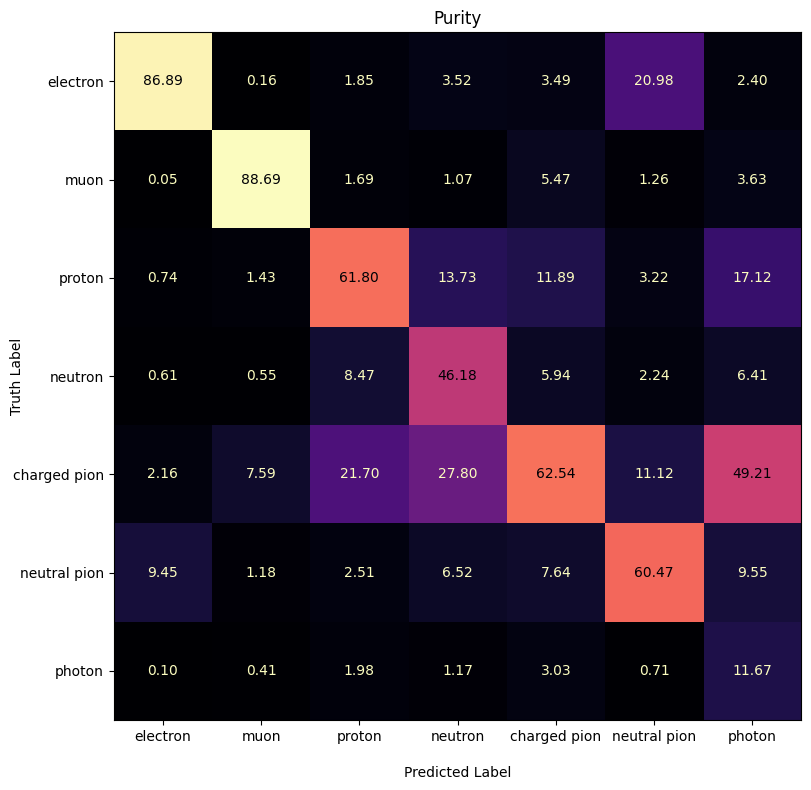

In [42]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    total_predictions.numpy(), 
    normalize='pred',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Purity")
plt.tight_layout()

In [43]:
from sklearn.metrics import roc_curve, auc

/home/roblesee/mambaforge/envs/torch25/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


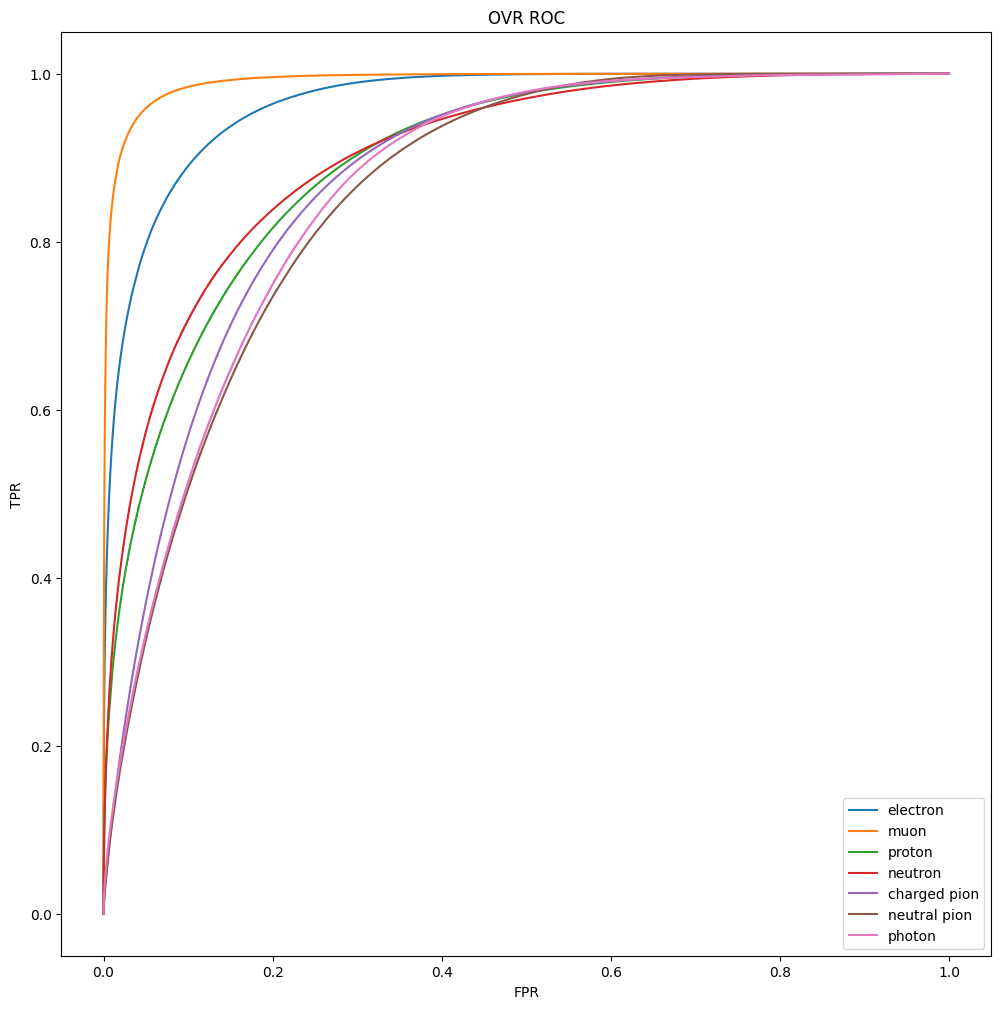

In [44]:
fig, ax = plt.subplots(figsize=(12, 12))

for class_index in LABEL_ORDER:
    class_index = class_index.item()
    fpr, tpr, thresholds = roc_curve(
        total_targets.numpy()[:],
        total_raws.numpy()[:,class_index],
        pos_label=class_index
    )

    ax.plot(fpr, tpr, label=CLASS_NAMES[class_index])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

ax.set_title("OVR ROC")
ax.legend()
plt.show()

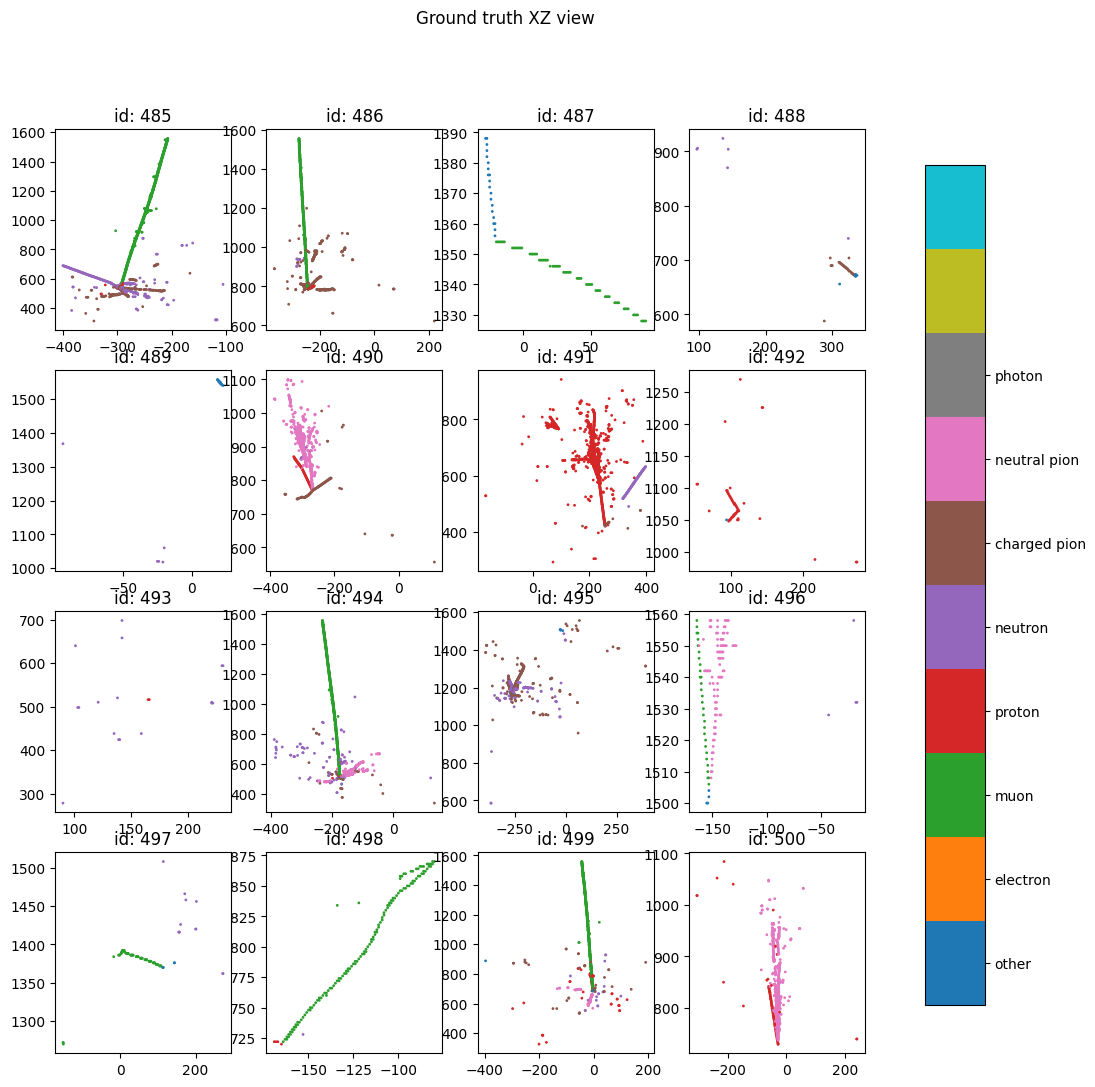

In [45]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_targets1[total_batch_idx1 == i+1+skip]
    ids = int(total_ids[i+1+skip].item())
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t, cmap="tab10")
    # ax.set_title("id: %d, unique: %s" % (ids, str(t[:,0].unique().tolist())))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth XZ view")
plt.show()

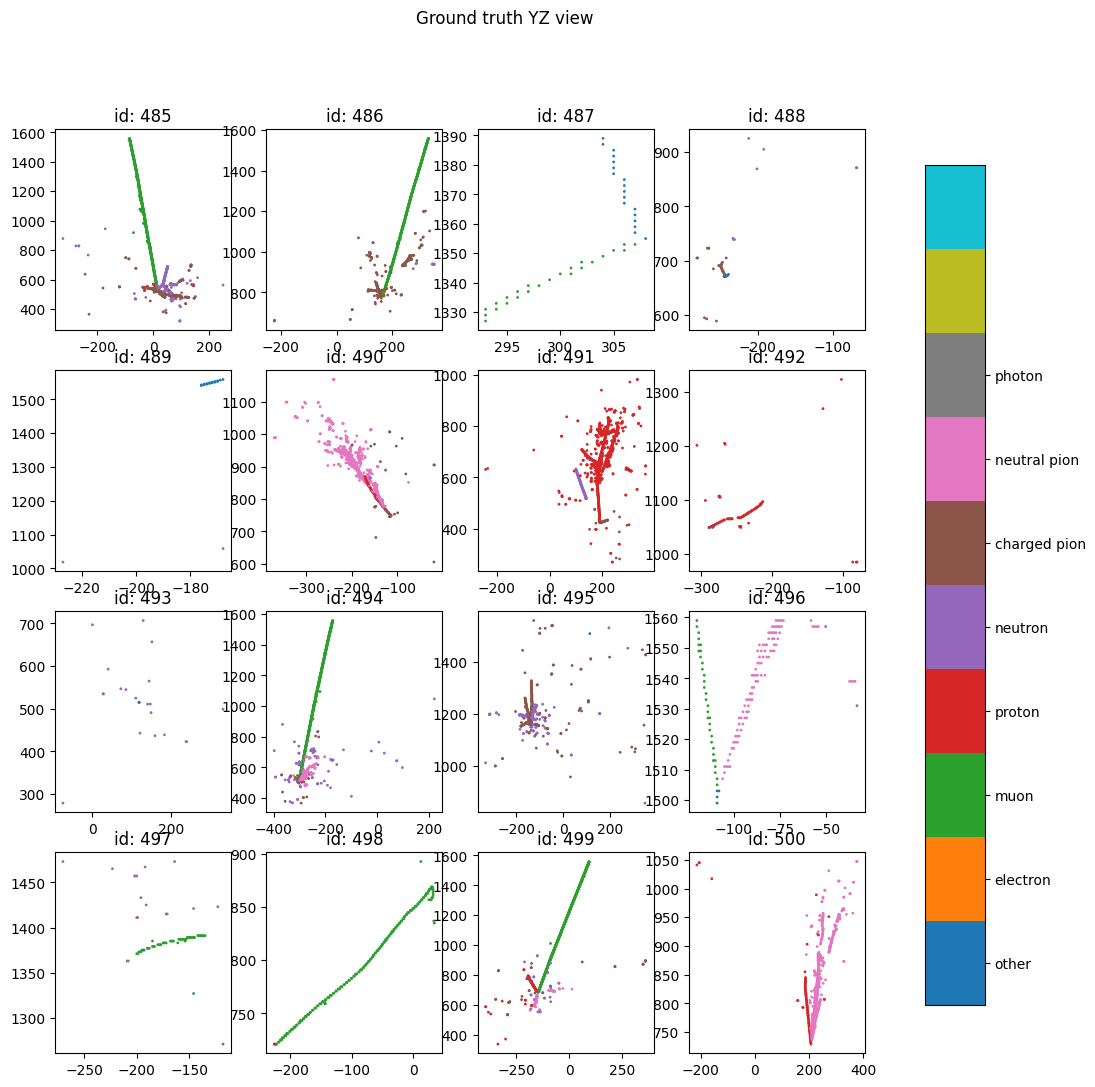

In [46]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords2[total_batch_idx2 == i+1+skip]
    t = total_targets2[total_batch_idx2 == i+1+skip]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t, cmap="tab10")
    ids = int(total_ids[i+1+skip].item())
    # ax.set_title("unique: %s" % str(t[:,0].unique().tolist()))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth YZ view")
plt.show()

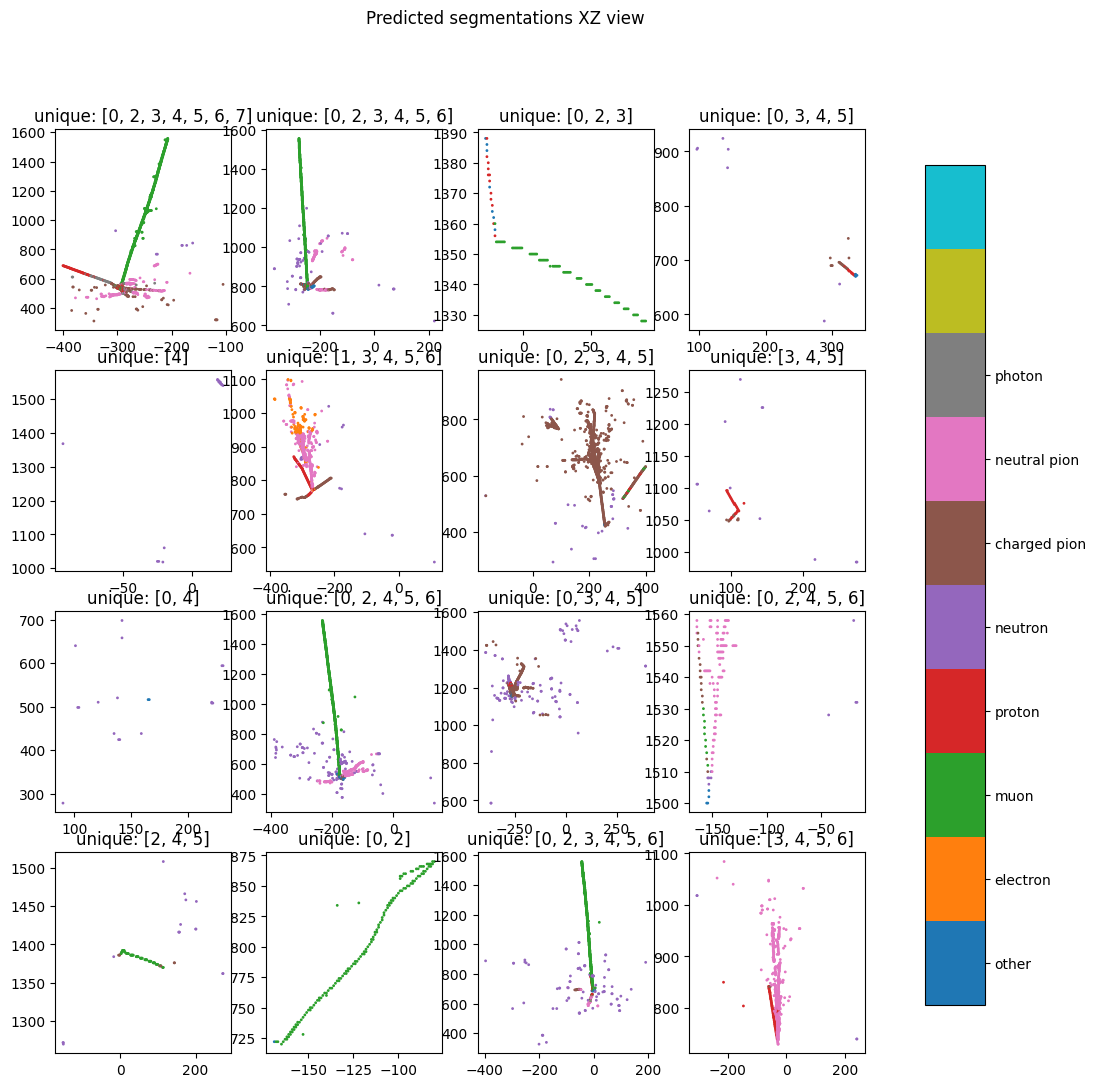

In [47]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_predictions1[total_batch_idx1 == i+1+skip]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations XZ view")
plt.show()

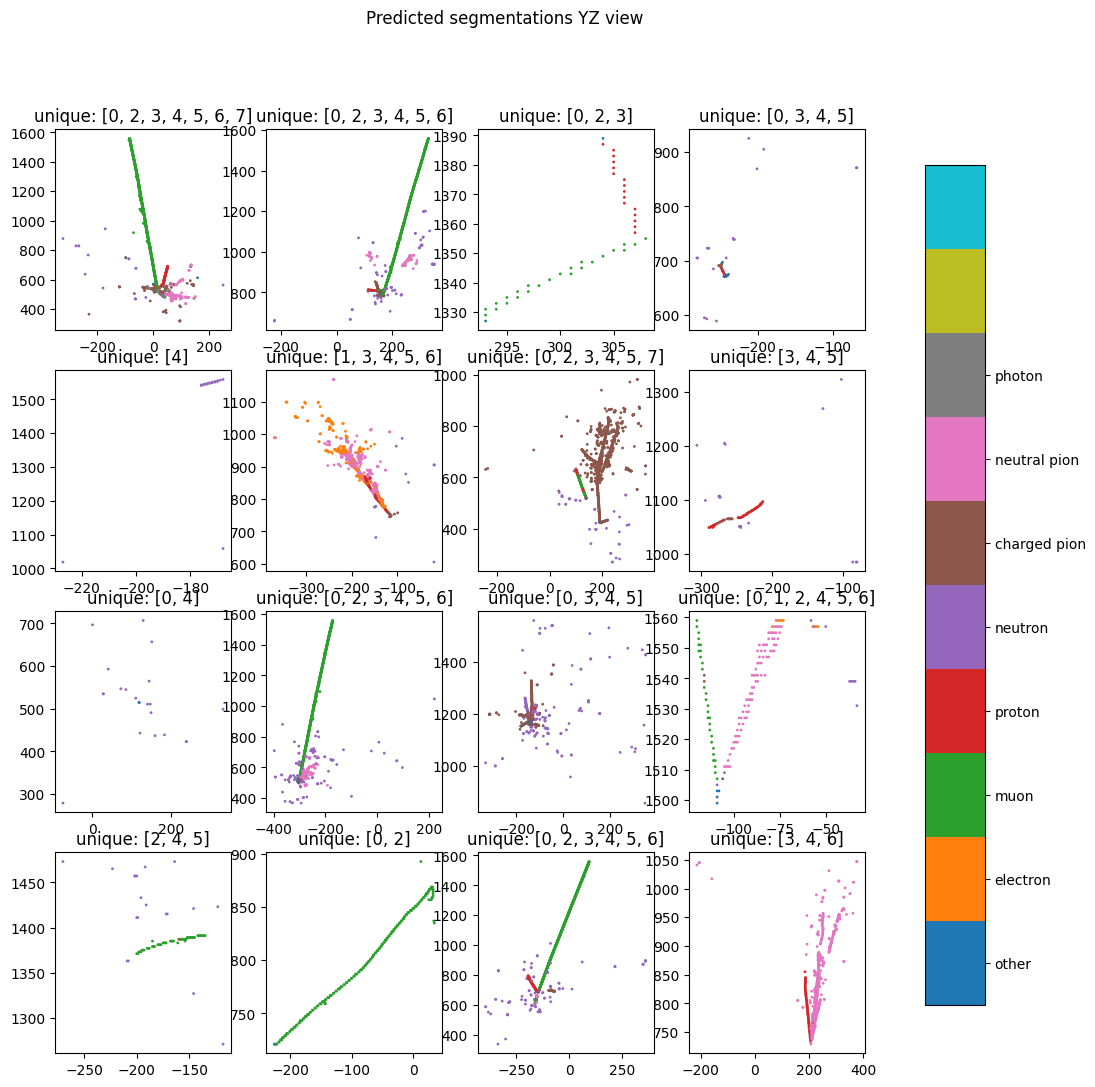

In [48]:
skip = 16*30
fig, axs = plt.subplots(4, 4, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords2[total_batch_idx2 == i+1+skip]
    t = total_predictions2[total_batch_idx2 == i+1+skip]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations YZ view")
plt.show()

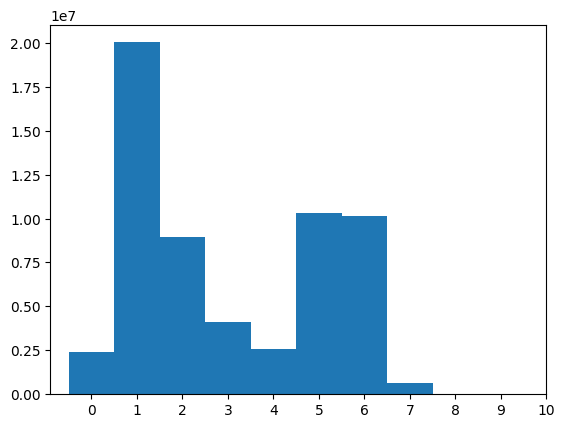

In [49]:
data = range(6)
data = np.array(total_targets)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(11))
plt.show()

In [50]:
total_targets.shape

torch.Size([59132010])

# Distribution of values

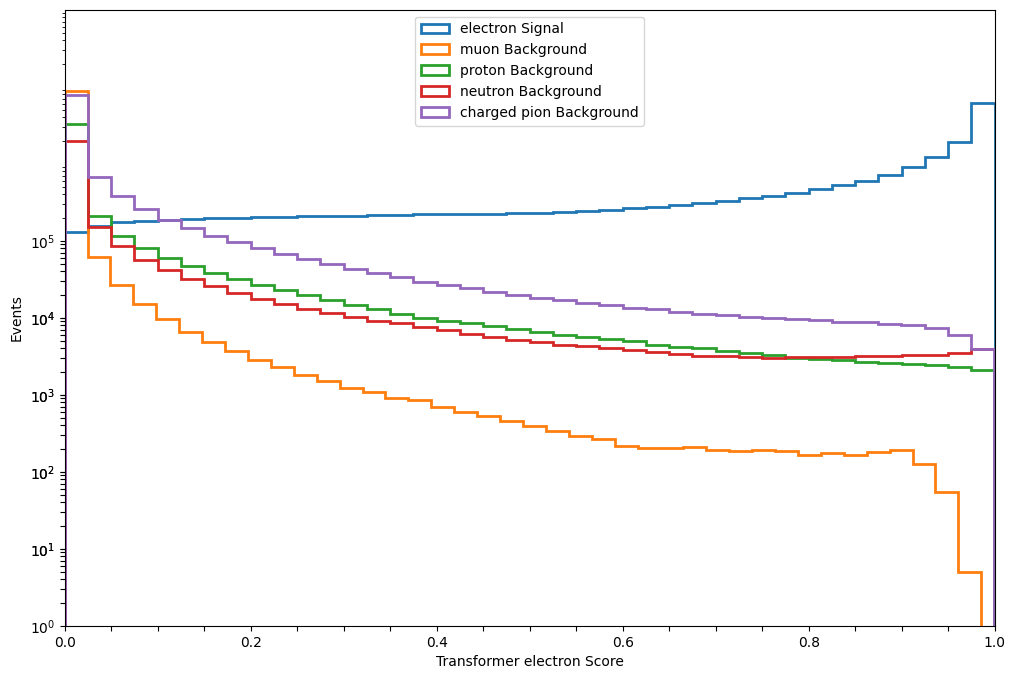

In [51]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

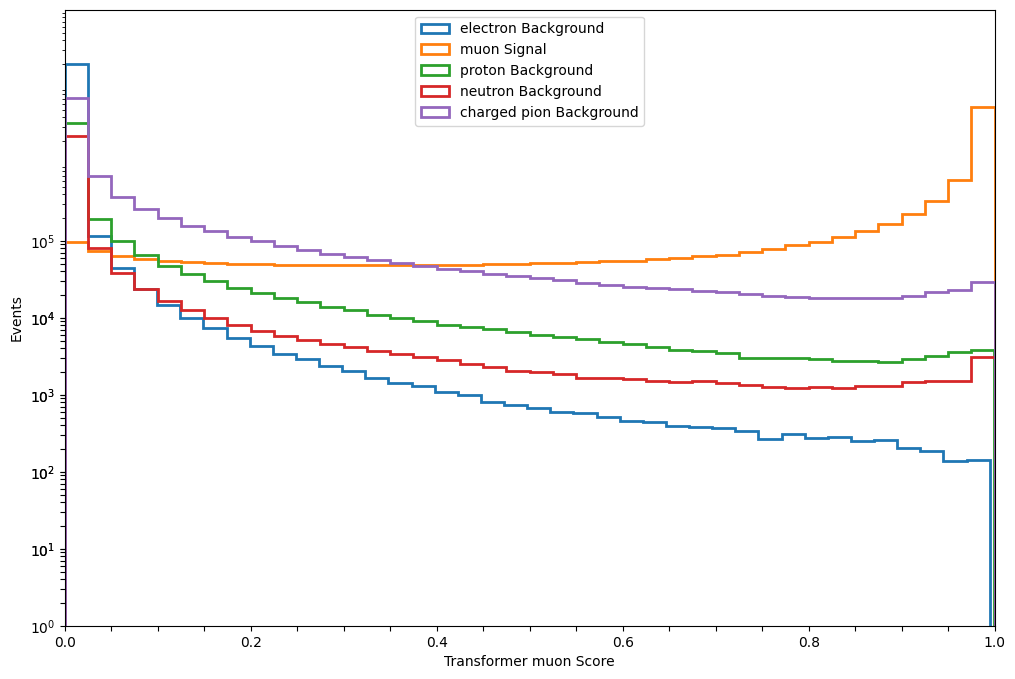

In [52]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 2
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

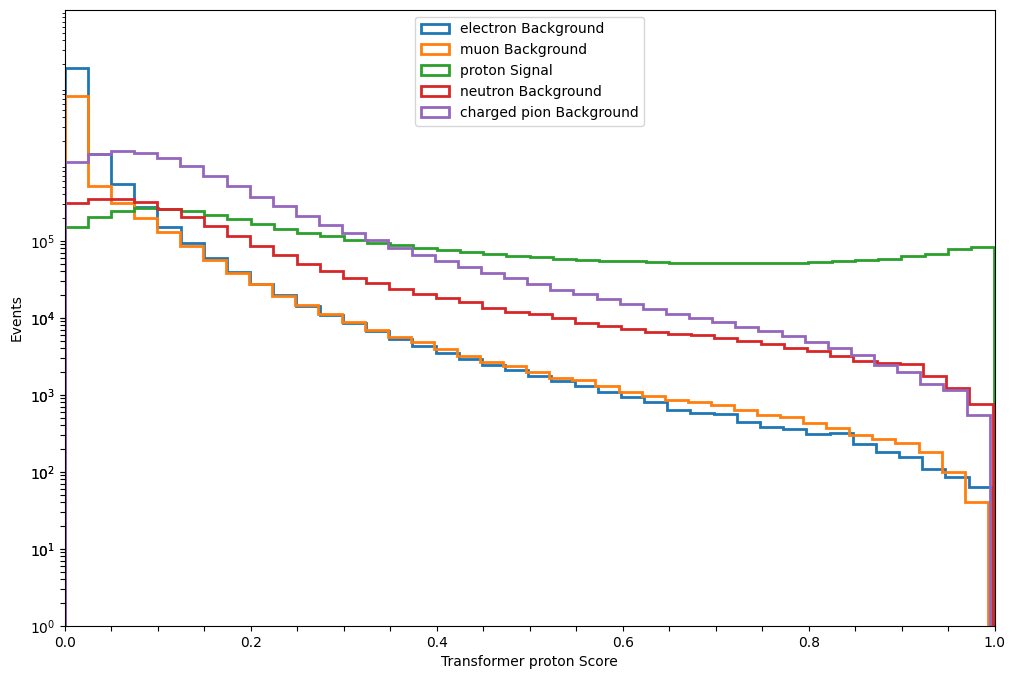

In [53]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 3
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

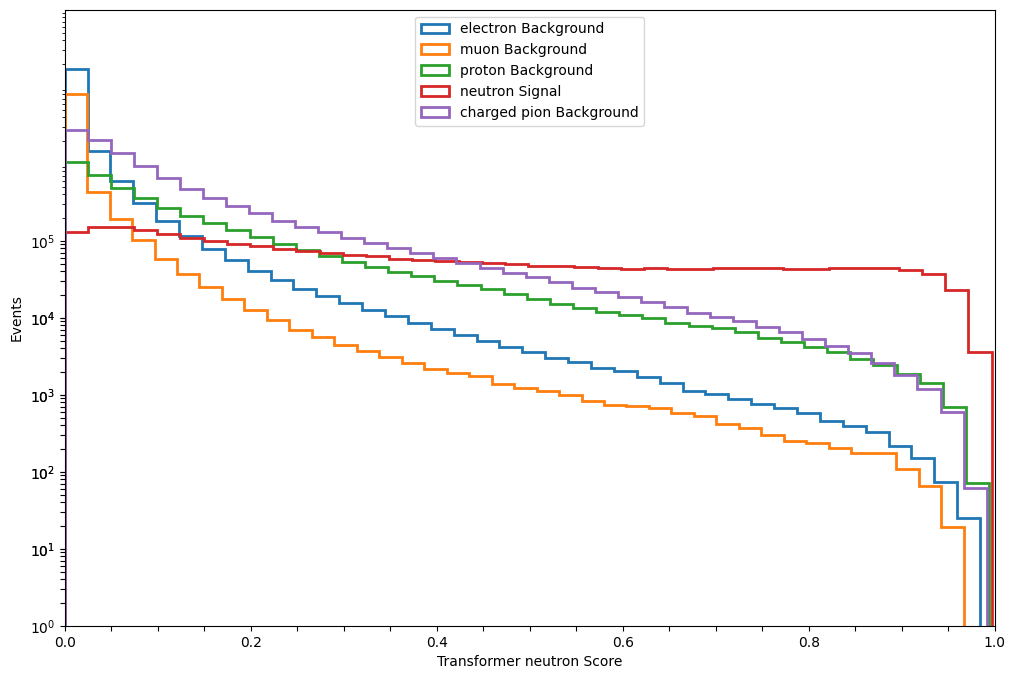

In [54]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 4
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

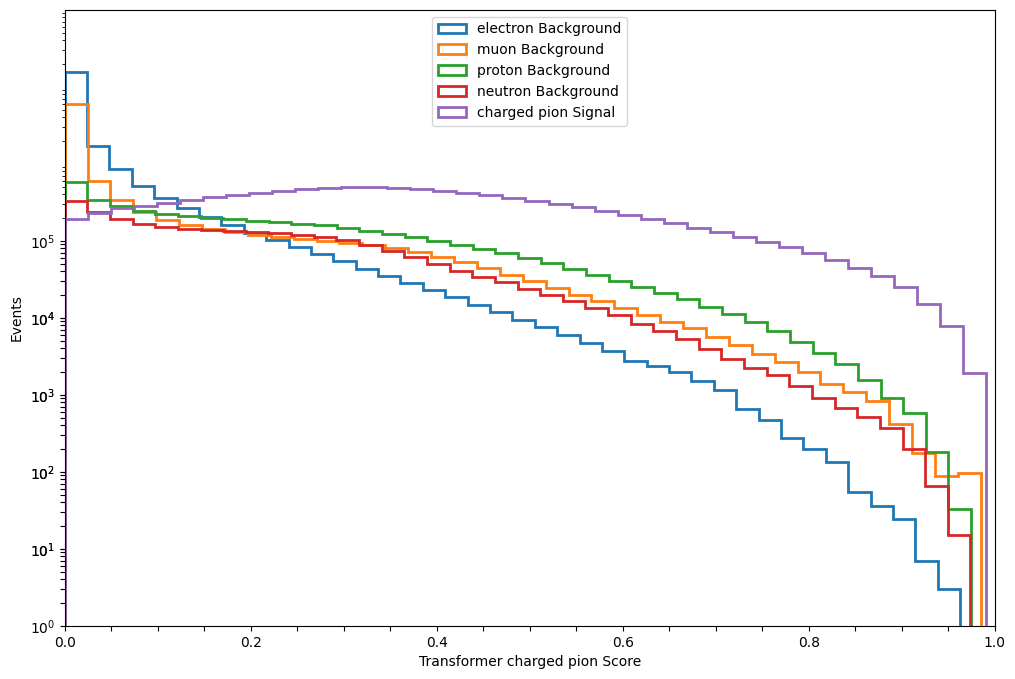

In [55]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 5
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

# Per class distribution

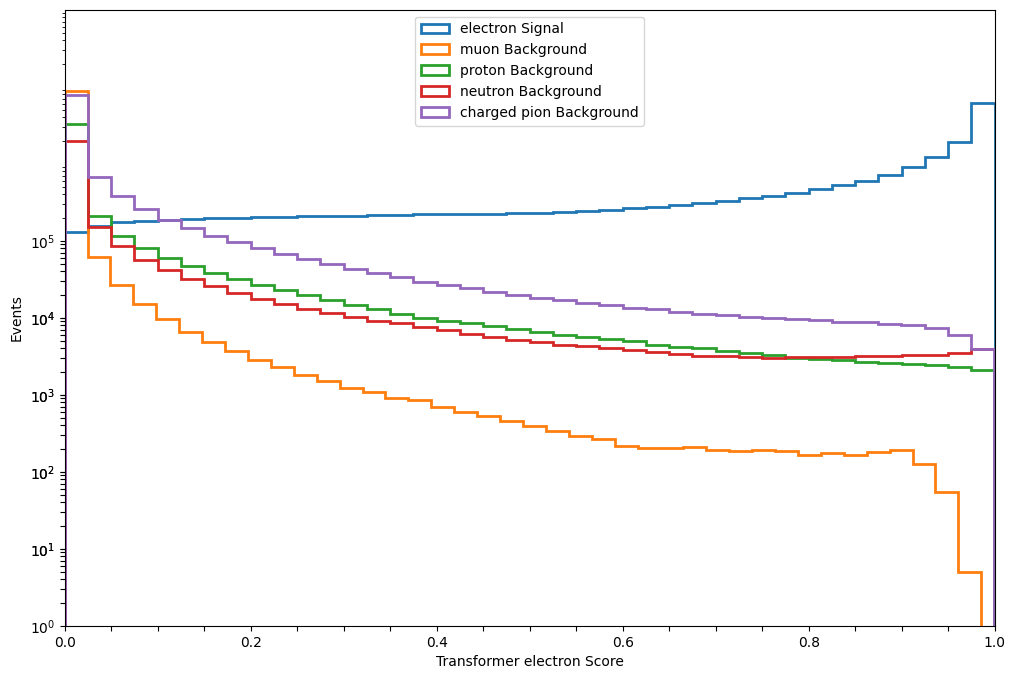

In [56]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

# Other

In [57]:
total_targets.shape

torch.Size([59132010])

In [58]:
tp.shape

torch.Size([59132010, 8])

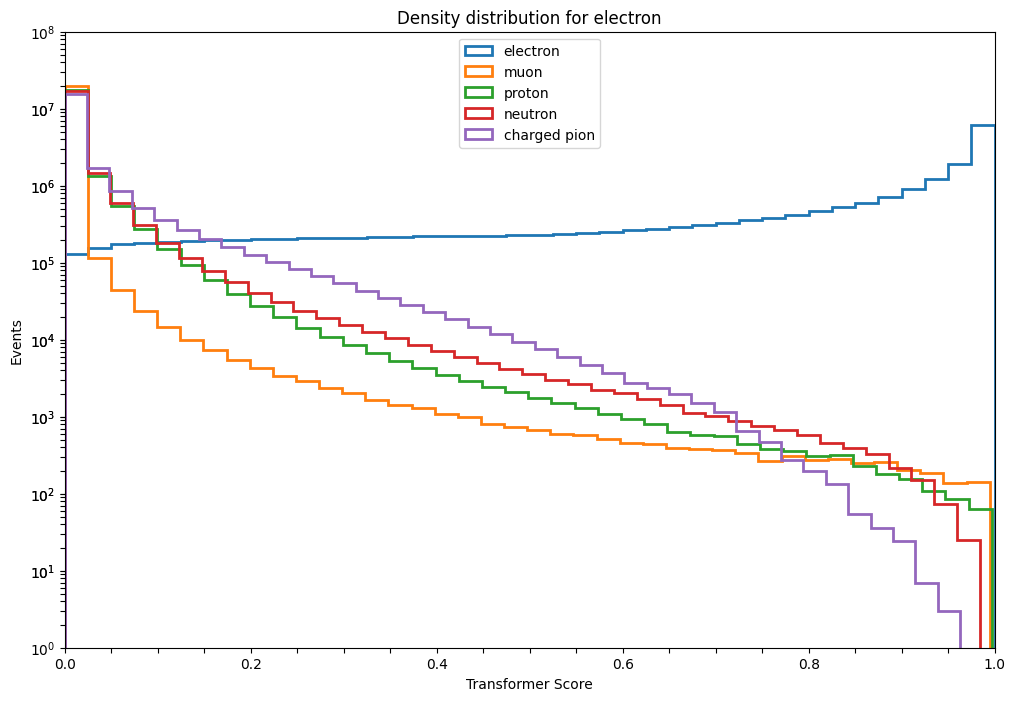

In [59]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

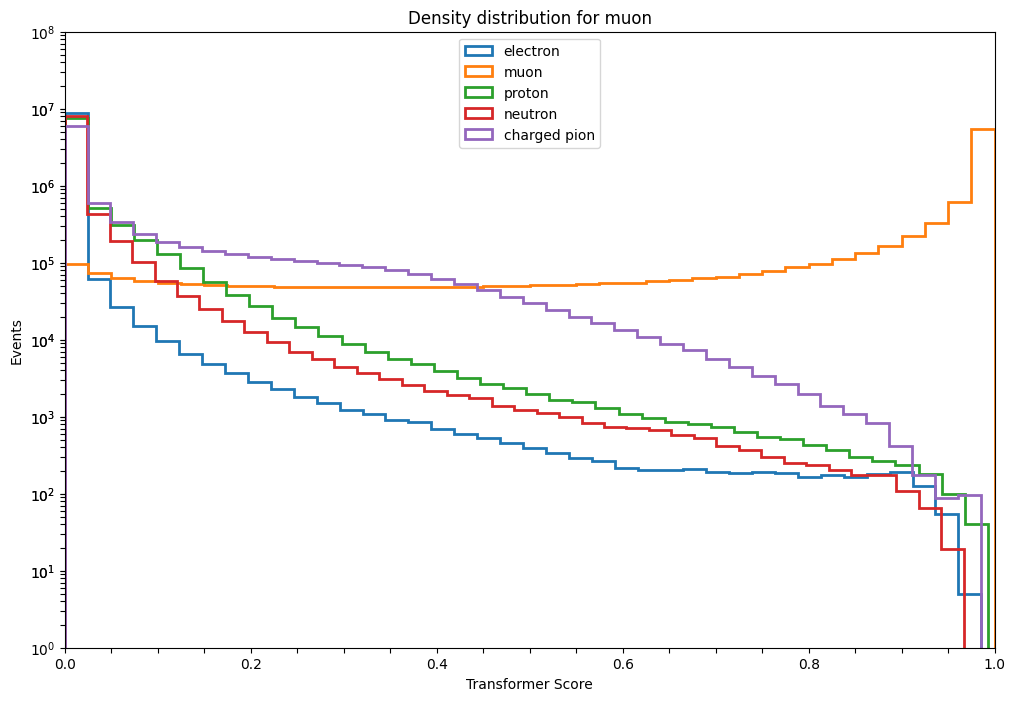

In [60]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 2
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

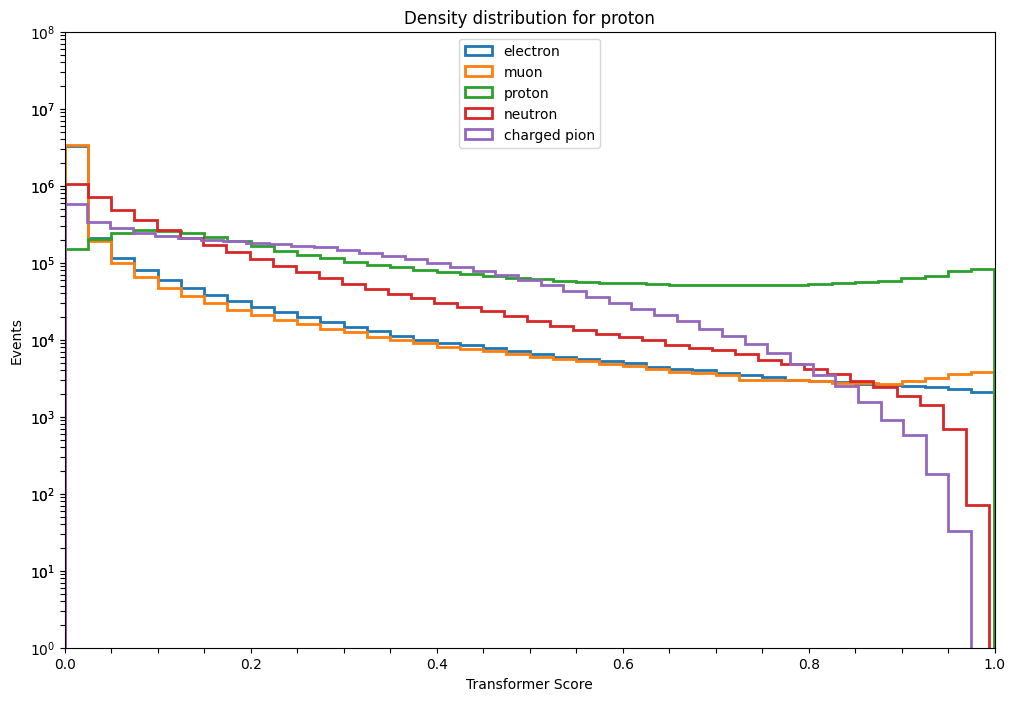

In [61]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 3
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

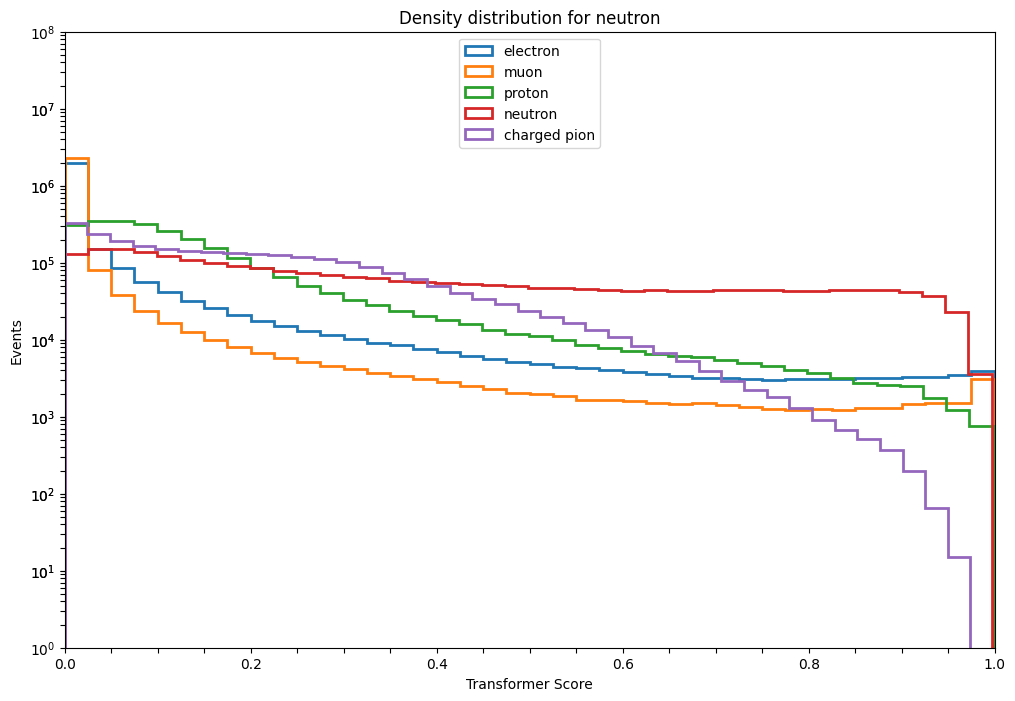

In [62]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 4
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

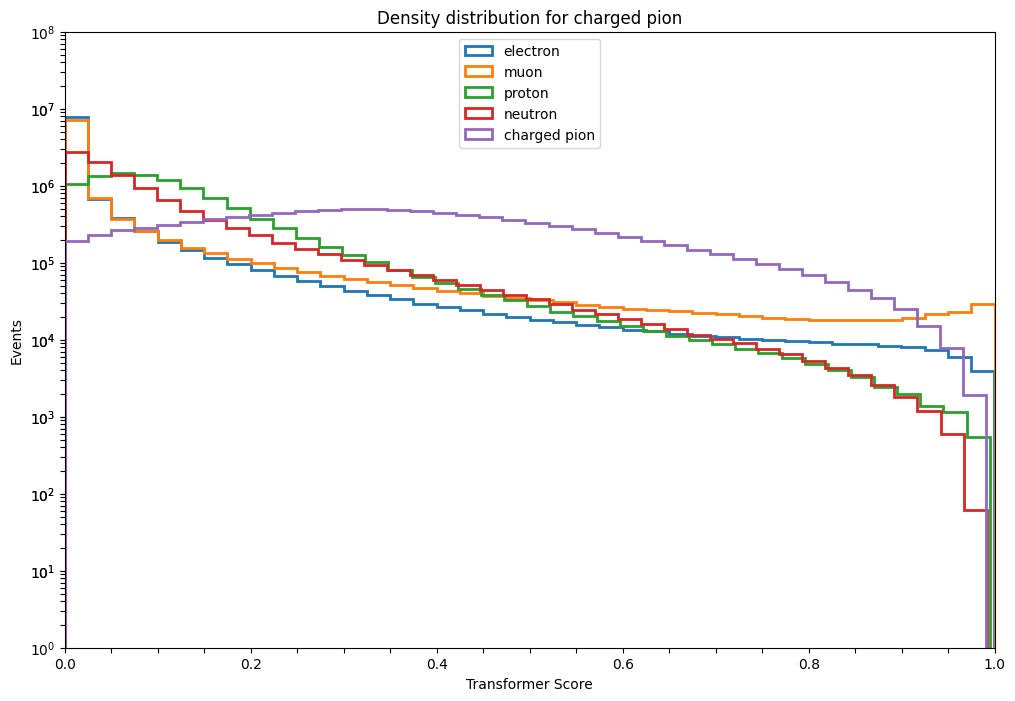

In [63]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 5
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

In [64]:
total_object_targets1

tensor([3, 3, 1,  ..., 2, 2, 2])

In [65]:
total_object_predictions1

tensor([26, 26,  5,  ..., 22, 22, 22])

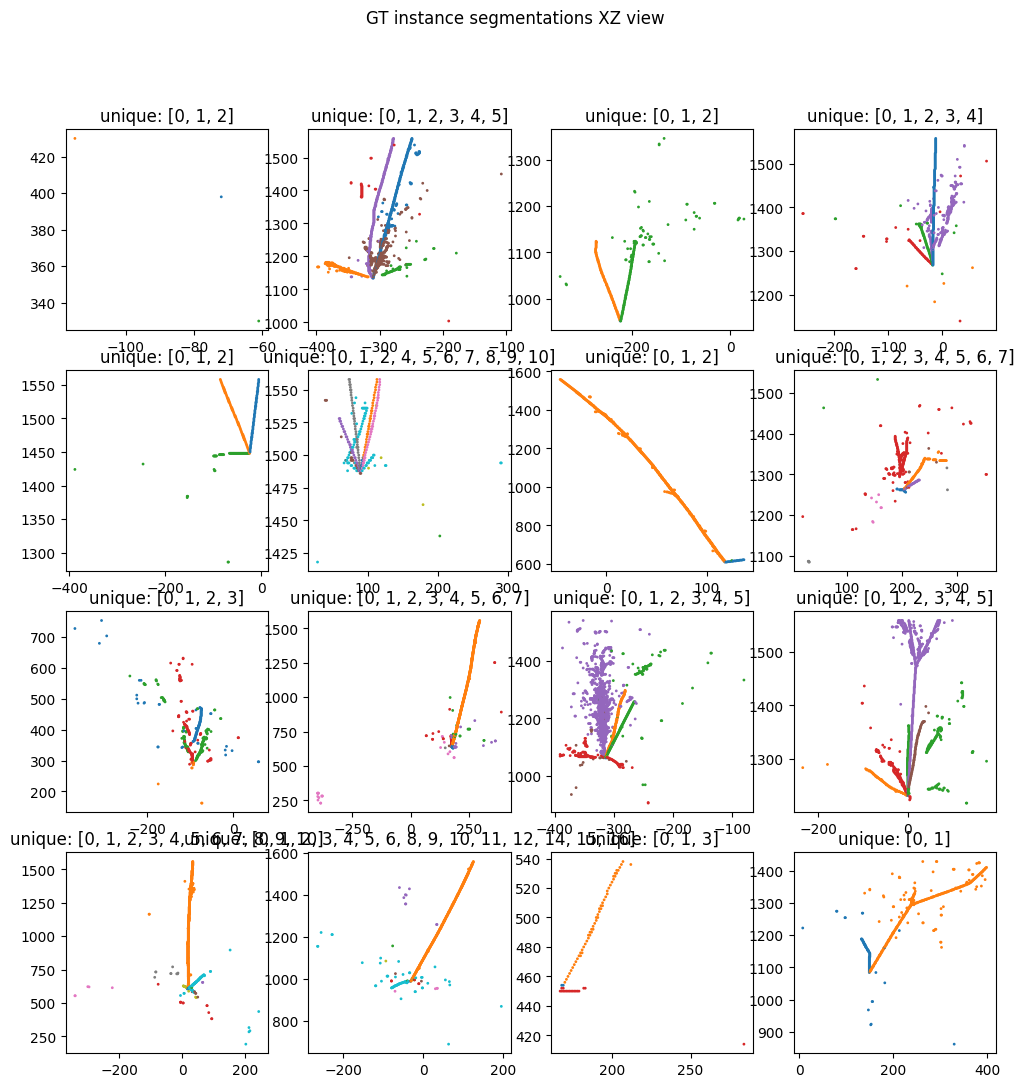

In [66]:
skip = 2*16
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_object_targets1[total_batch_idx1 == i+1+skip]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
plt.suptitle("GT instance segmentations XZ view")
plt.show()

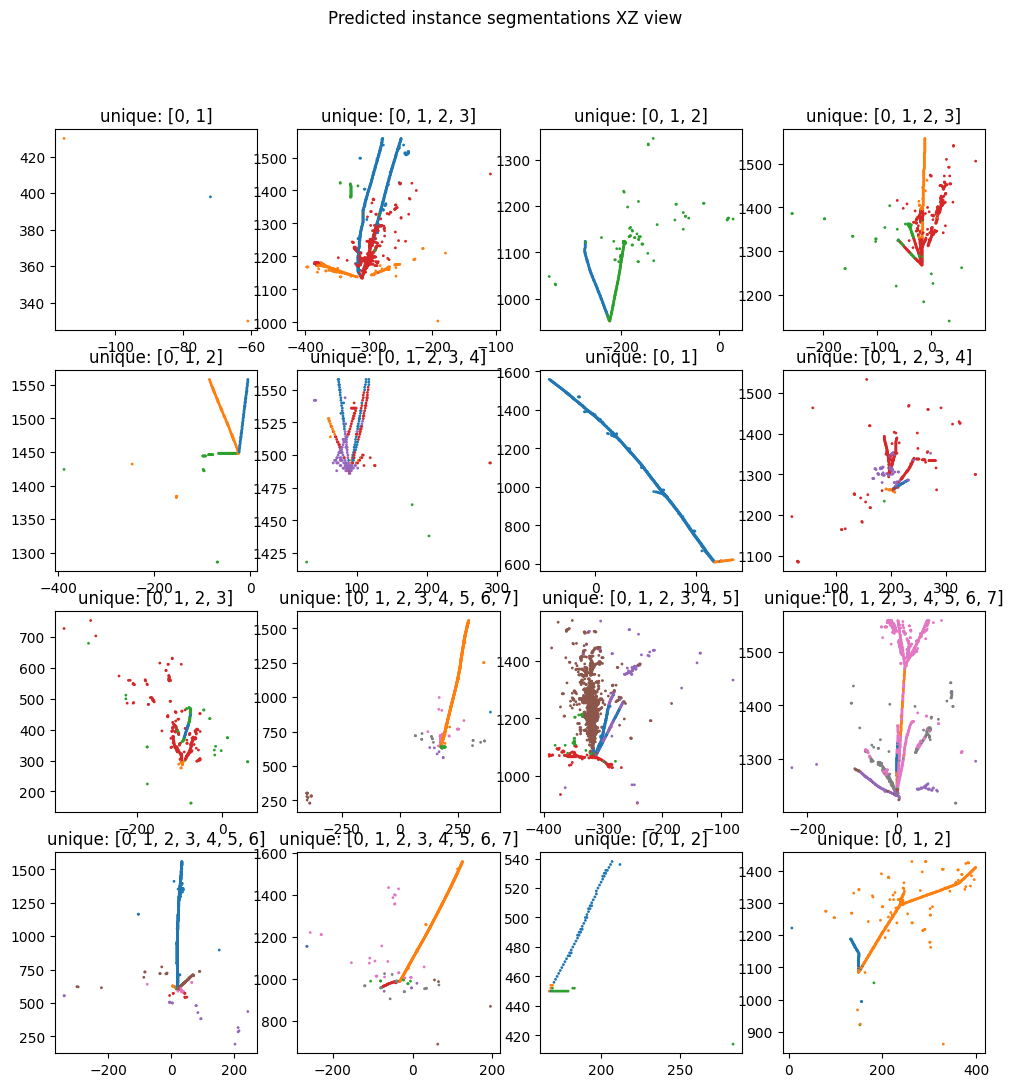

In [67]:
skip = 2*16
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_object_predictions1[total_batch_idx1 == i+1+skip]
    _, t = torch.unique(t, return_inverse=True)
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
plt.suptitle("Predicted instance segmentations XZ view")
plt.show()

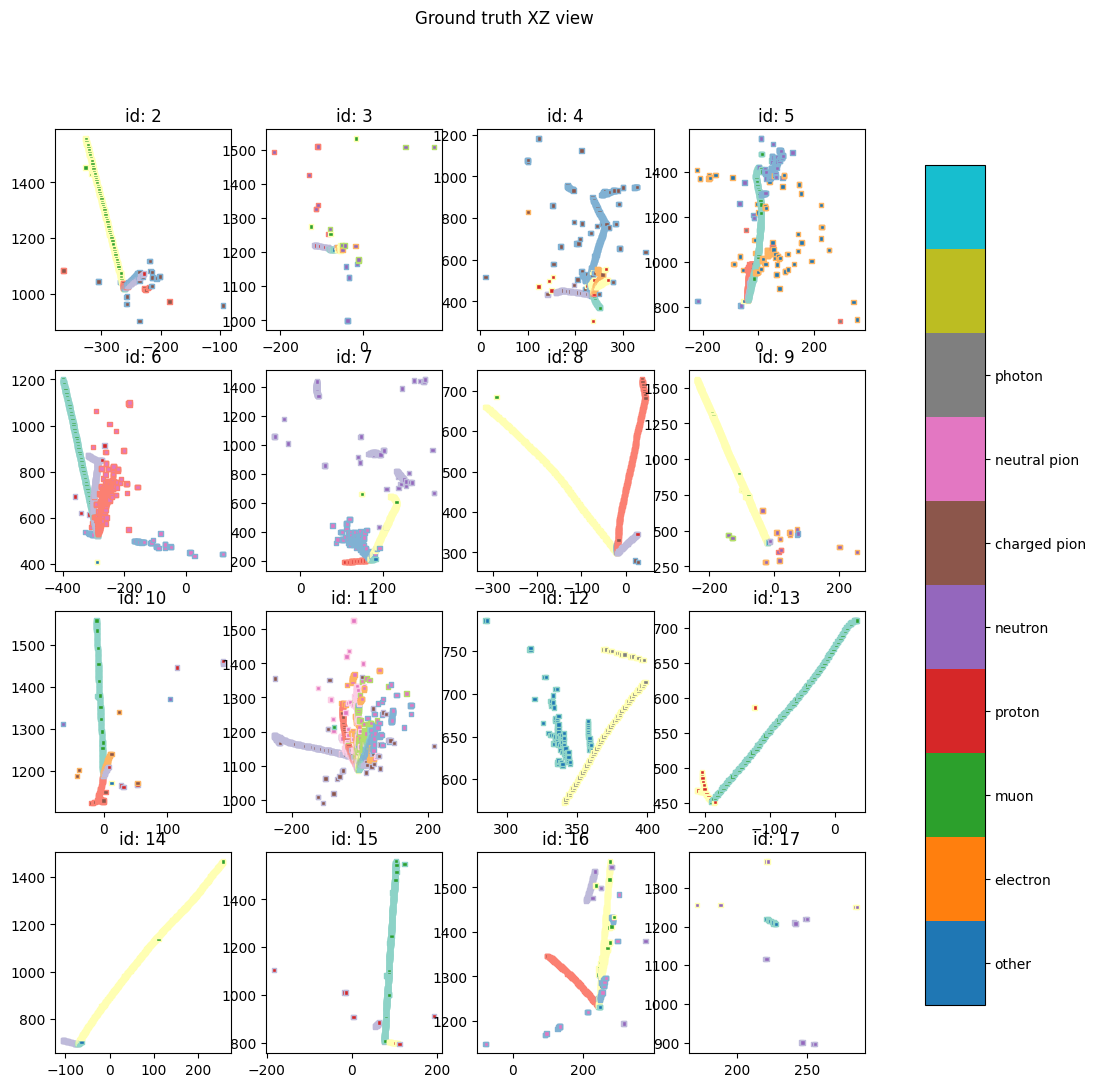

In [68]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+skip]
    t = total_targets1[total_batch_idx1 == i+skip]
    to = total_object_targets1[total_batch_idx1 == i+skip]
    toc = plt.cm.Set3(to)
    ids = int(total_ids[i+skip].item())
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    # ax.set_title("id: %d, unique: %s" % (ids, str(t[:,0].unique().tolist())))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth XZ view")
plt.show()

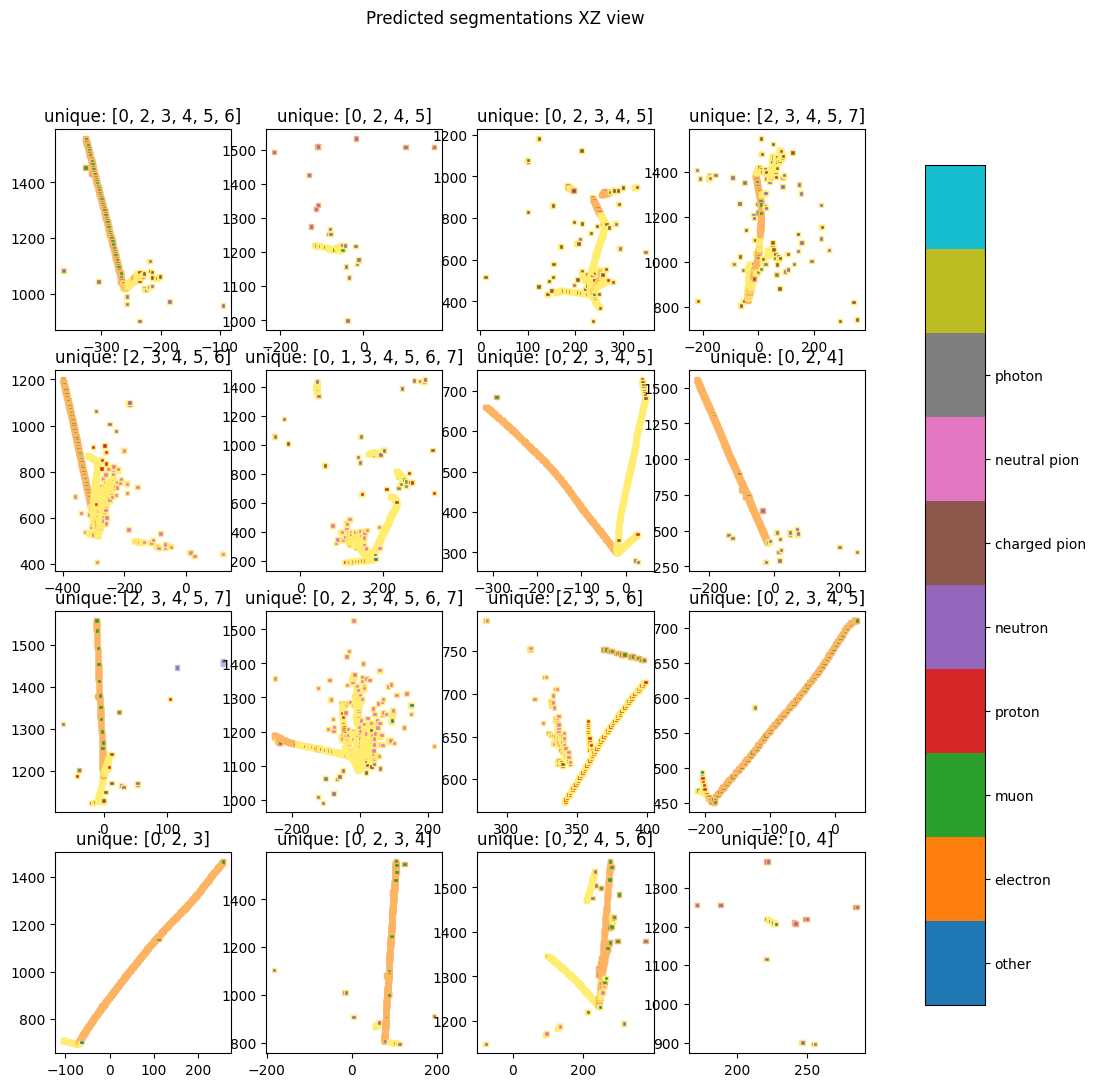

In [69]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+skip]
    t = total_predictions1[total_batch_idx1 == i+skip]
    to = total_object_predictions1[total_batch_idx1 == i+skip]
    toc = plt.cm.Set3(to)
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations XZ view")
plt.show()

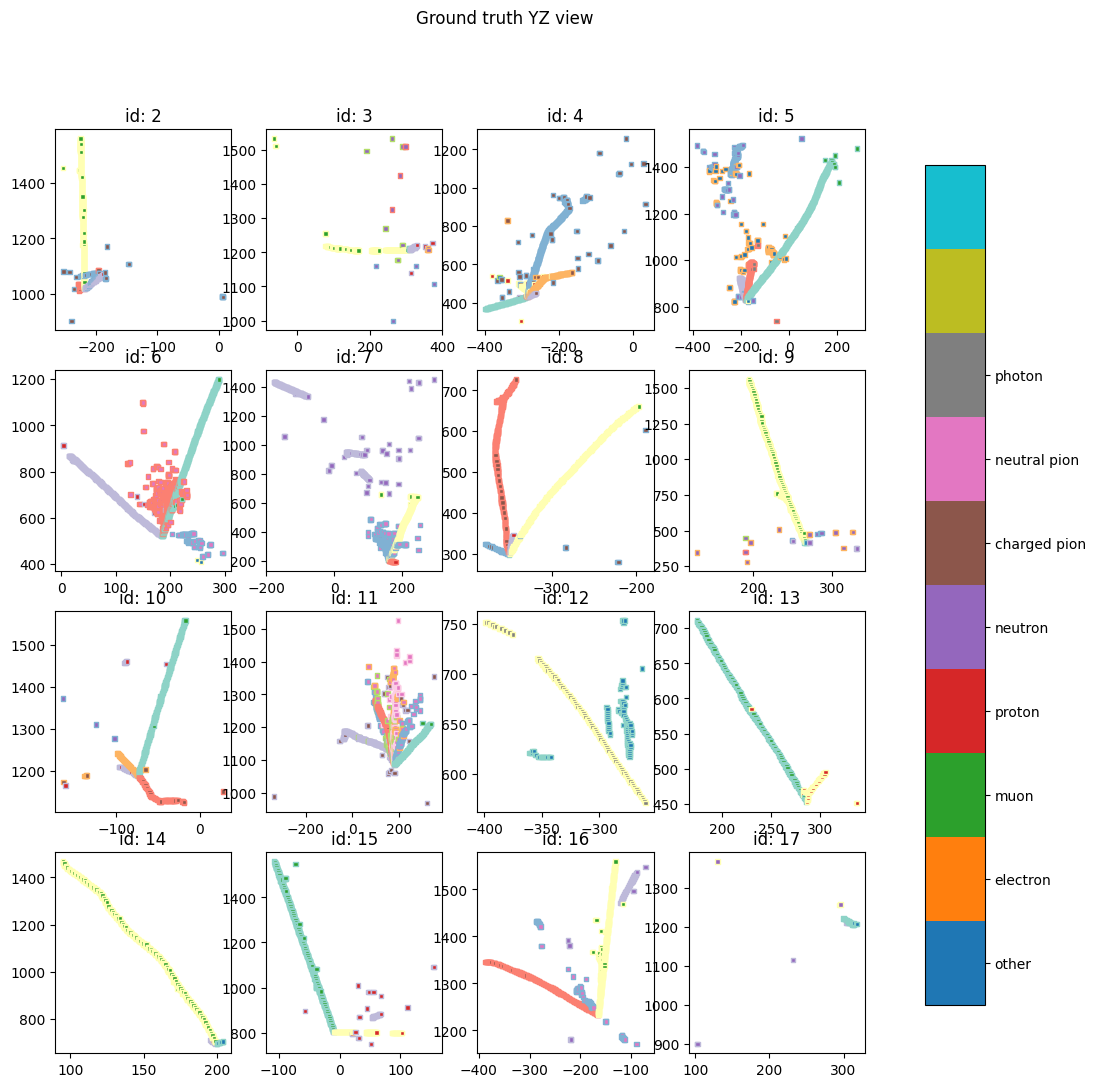

In [70]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords2[total_batch_idx2 == i+skip]
    t = total_targets2[total_batch_idx2 == i+skip]
    to = total_object_targets2[total_batch_idx2 == i+skip]
    toc = plt.cm.Set3(to)
    ids = int(total_ids[i+skip].item())
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    # ax.set_title("id: %d, unique: %s" % (ids, str(t[:,0].unique().tolist())))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth YZ view")
plt.show()

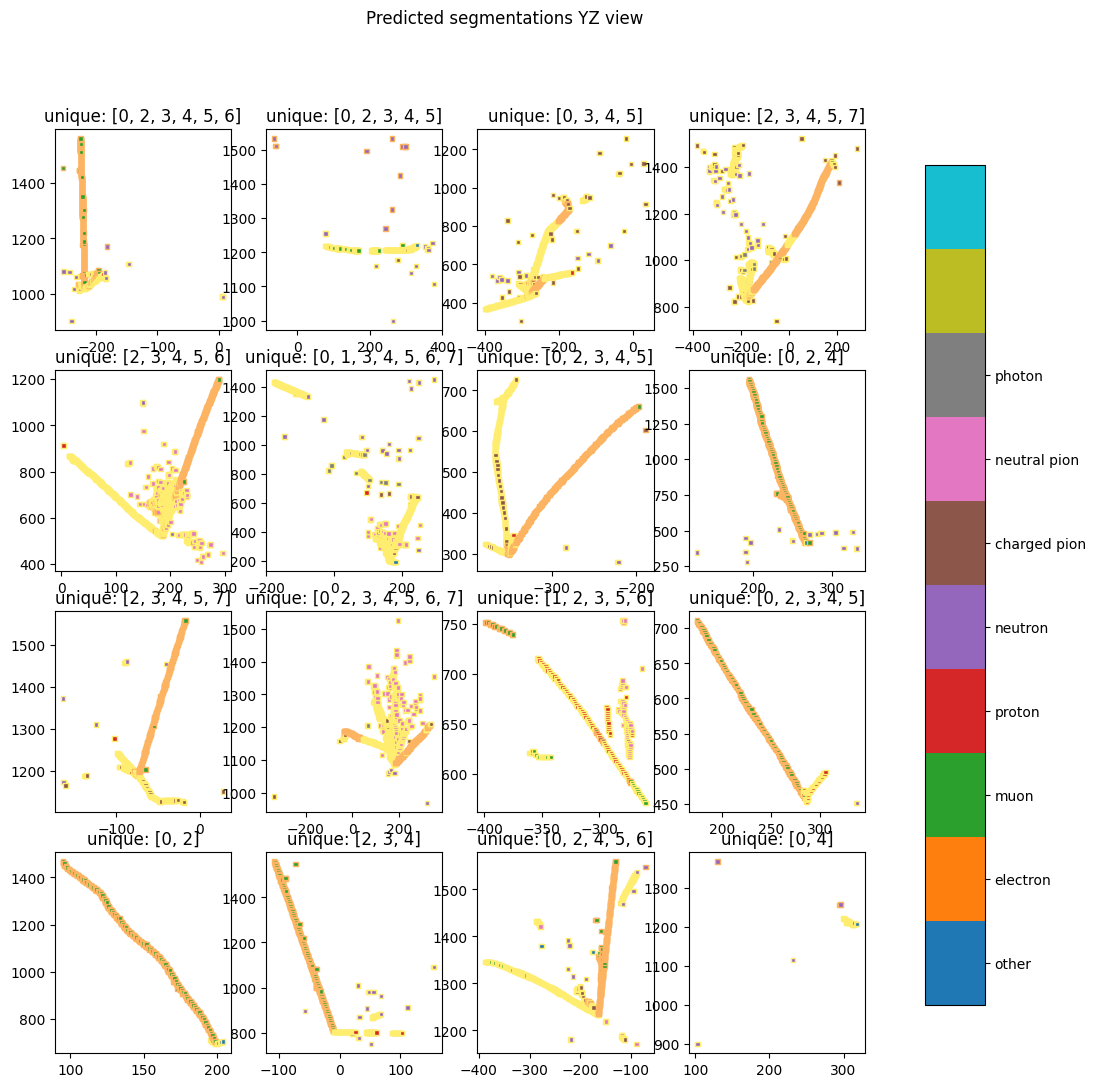

In [71]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords2[total_batch_idx2 == i+skip]
    t = total_predictions2[total_batch_idx2 == i+skip]
    to = total_object_predictions2[total_batch_idx2 == i+skip]
    toc = plt.cm.Set3(to)
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations YZ view")
plt.show()

In [72]:
# debug block
"""
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1) & (object_targets1 < num_objects))
    mask2 = ((targets2 != -1) & (object_targets2 < num_objects))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    object_preds = -F.log_softmax(logits, dim=-1)

    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*10)+targets, dim_size=10*batch_size, reduce="sum", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 10, -1))
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        print(i)
        print(((batches)*10+targets)[batches==i])
        print(targets[batches==i])
        print(torch.unique(targets[batches==i]))
        print(pre_reshape_cost_matrix[(i)*10:(i+1)*10])
        print(cm)
        
        if i == 3: break
        
        row_ind, col_ind = linear_sum_assignment(cm, maximize=False)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        print(row_ind, col_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    #row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    #col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    #indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    break
""";

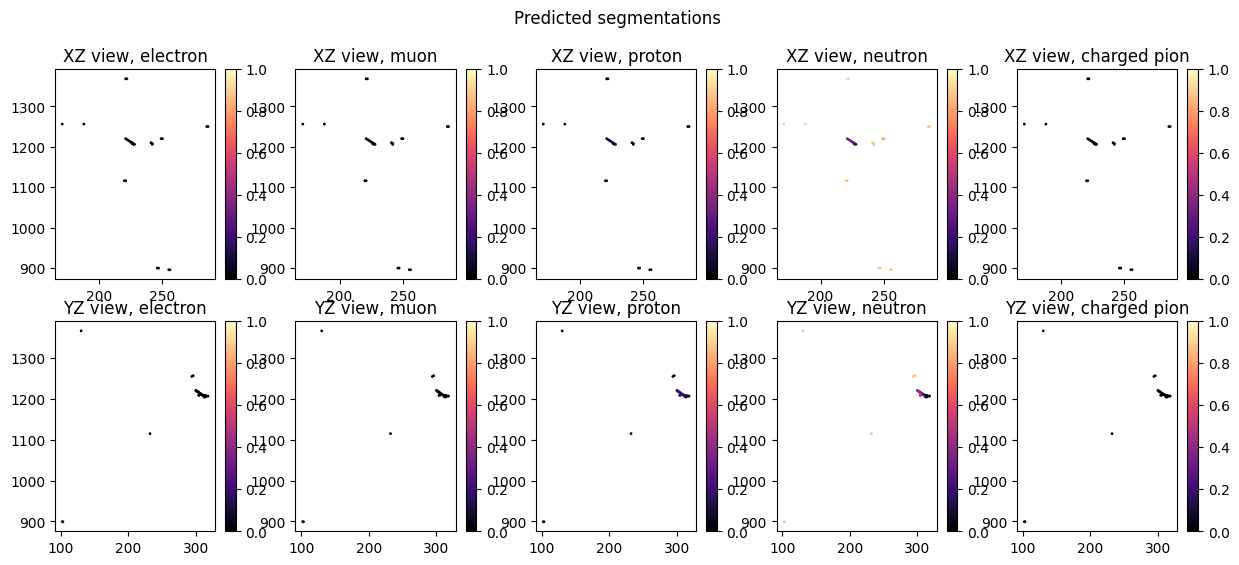

In [73]:
fig, axs = plt.subplots(2, 5, sharex=False, sharey=False, figsize=(5*3, 2*3))
n = 15
for i, ax in enumerate(axs[0]):
    c = total_coords1[total_batch_idx1 == n+1]
    t = total_probabilities1[total_batch_idx1 == n+1, i+1]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=0, vmax=1, c=t[:], cmap="magma")
    plt.colorbar(im, ax=ax)
    ax.set_title(f"XZ view, {CLASS_NAMES[i+1]}")
    
for i, ax in enumerate(axs[1]):
    c = total_coords2[total_batch_idx2 == n+1]
    t = total_probabilities2[total_batch_idx2 == n+1, i+1]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=0, vmax=1, c=t[:], cmap="magma")
    plt.colorbar(im, ax=ax)
    ax.set_title(f"YZ view, {CLASS_NAMES[i+1]}")
plt.suptitle("Predicted segmentations")
plt.show()

In [74]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [0]*8
n_efficiencies = [0]*8
sum_purities = [0]*8
n_purities = [0]*8

n_corr = 0
n_tot = 0
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )

    num_objects = 32
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < num_objects))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < num_objects))

    #mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    #mask2 = ((targets2 != -1))#(object_targets2 < num_objects))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    object_targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    targets = torch.cat((targets1[mask1], targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    
    object_preds = F.one_hot(object_preds, num_classes=num_objects)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(object_targets, num_classes=num_objects), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(targets, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="mean", dim=0)

    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, num_objects, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds]/n_true_per_prong[indices, row_inds]
    purs = cost_matrix[indices, row_inds, col_inds]/n_predictions_per_prong[indices, col_inds]
    n_corr += cost_matrix[indices, row_inds, col_inds].sum()
    n_tot += n_predictions_per_prong[indices, col_inds].sum()
    
    for i in range(8):
        ieffs = effs[batch_target == i]
        n_efficiencies[i] += torch.isfinite(ieffs).sum()
        sum_efficiencies[i] += ieffs[torch.isfinite(ieffs)].sum()
        ipurs = purs[batch_target == i]
        n_purities[i] += torch.isfinite(ipurs).sum()
        sum_purities[i] += ipurs[torch.isfinite(ipurs)].sum()
    

100%|██████████████████████████████████████████████████████████████| 1248/1248 [03:19<00:00,  6.26it/s]


In [75]:
print("Prong accuracy: %.03f" % (n_corr/n_tot))

Prong accuracy: 0.779


In [76]:
sum_efficiencies = torch.tensor(sum_efficiencies)
n_efficiencies = torch.tensor(n_efficiencies)
sum_purities = torch.tensor(sum_purities)
n_purities = torch.tensor(n_purities)

In [77]:
for i in range(8):
    print(CLASS_NAMES[i])
    print("Efficiency: ", (sum_efficiencies[i]/n_efficiencies[i]).item())
    print("Purity: ", (sum_purities[i]/n_purities[i]).item())

other
Efficiency:  0.4642314314842224
Purity:  0.36023271083831787
electron
Efficiency:  0.8865309953689575
Purity:  0.8535307049751282
muon
Efficiency:  0.8645766973495483
Purity:  0.8754843473434448
proton
Efficiency:  0.5372558236122131
Purity:  0.703484058380127
neutron
Efficiency:  0.21995046734809875
Purity:  0.5668788552284241
charged pion
Efficiency:  0.4451783299446106
Purity:  0.6298549175262451
neutral pion
Efficiency:  0.6136685609817505
Purity:  0.6678975820541382
photon
Efficiency:  0.4990904927253723
Purity:  0.6294037103652954


In [78]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [[] for _ in range(6)]
n_efficiencies = [[] for _ in range(6)]
sum_purities = [[] for _ in range(6)]
n_purities = [[] for _ in range(6)]
n_trues = [[] for _ in range(6)]
n_predicteds = [[] for _ in range(6)]

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 10))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    class_targets = torch.cat((targets1[mask1], targets2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=10)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*10)+targets, dim_size=10*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=10), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(class_targets, (batches*10)+targets, dim_size=10*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 10, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds].to(float)/n_true_per_prong[indices, row_inds].to(float)
    purs = cost_matrix[indices, row_inds, col_inds].to(float)/n_predictions_per_prong[indices, col_inds].to(float)
    
    for i in range(6):
        ntrues = n_true_per_prong[indices, row_inds][batch_target == i]
        npredicteds = n_predictions_per_prong[indices, col_inds][batch_target == i]
        
        ieffs = effs[batch_target == i]
        ipurs = purs[batch_target == i]
        mask = torch.isfinite(ieffs) & torch.isfinite(ipurs)
        sum_efficiencies[i].append(ieffs[mask].detach().cpu())
        sum_purities[i].append(ipurs[mask].detach().cpu())
        n_trues[i].append(ntrues[mask].detach().cpu())
        n_predicteds[i].append(npredicteds[mask].detach().cpu())

  0%|                                                                         | 0/1248 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [16,0,0], thread: [79,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [16,0,0], thread: [99,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"
` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [16,0,0], thread: [116,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [28,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [28,0,0], thread: [8,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "in

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 10))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    class_targets = torch.cat((targets1[mask1], targets2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=10)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*10)+targets, dim_size=10*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=10), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(class_targets, (batches*10)+targets, dim_size=10*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 10, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    localmask=indices==12
    effs = cost_matrix[indices[localmask], row_inds[localmask], col_inds[localmask]].to(float)/n_true_per_prong[indices[localmask], row_inds[localmask]].to(float)
    purs = cost_matrix[indices, row_inds, col_inds].to(float)/n_predictions_per_prong[indices, col_inds].to(float)
    print(ids[indices[localmask]])
    print(cost_matrix[indices[localmask], row_inds[localmask], col_inds[localmask]].to(float))
    # print(cost_matrix[indices[localmask], row_inds[localmask], col_inds[localmask]].to(float).sum())
    print(n_true_per_prong[indices[localmask], row_inds[localmask]].to(float))
    # print(n_true_per_prong[indices[localmask], row_inds[localmask]].to(float).sum())
    print([CLASS_NAMES[t.item()] for t in batch_target[localmask]])
    print(effs)
    
    for i in range(6):
        ieffs = effs[batch_target == i]
        ipurs = purs[batch_target == i]
        mask = torch.isfinite(ieffs) & torch.isfinite(ipurs)
        sum_efficiencies[i].append(ieffs[mask].detach().cpu())
        print(ieffs.detach().cpu())
        asdsf
        sum_purities[i].append(ipurs[mask].detach().cpu())

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"Efficiency distribution of class {name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"Purity distribution of class {name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean pur=%.02f"%mean_pur)
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i]).numpy()
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    mean_eff = efficiencies[nt>=3].mean()
    ax.set_title(f"Efficiency distribution of class {name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies[nt>=3], bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.suptitle("Efficiency distributions for prongs with num_hits>=3")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    mean_pur = purities[nt>=3].mean()
    ax.set_title(f"Purity distribution of class {name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities[nt>=3].numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean pur=%.02f"%mean_pur)
    ax.legend()
plt.suptitle("Purity distributions for prongs with num_hits>=3")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(4*4, 2*4))
for i in range(1,6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    ax.set_title(f"Efficiency vs size of prong for class {name}")
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    efficiencies = torch.cat(sum_efficiencies[i]).detach().cpu().numpy()
    im = ax.hist2d(nt, efficiencies, bins=100)
    ax.set_xlabel("Size of prong")
    ax.set_ylabel("Efficiency")
    cbar = plt.colorbar(im[3], ax=ax)
    cbar.set_label("Count")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(4*4, 2*4))
for i in range(1,6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    ax.set_title(f"Efficiency vs size of prong for class {name}")
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    efficiencies = torch.cat(sum_efficiencies[i]).detach().cpu().numpy()
    mask = (nt < nt.max()*0.1) & (efficiencies > 0.8)
    im = ax.hist2d(nt[mask], efficiencies[mask], bins=100)
    ax.set_xlabel("Size of prong")
    ax.set_ylabel("Efficiency")
    cbar = plt.colorbar(im[3], ax=ax)
    cbar.set_label("Count")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(4*4, 2*4))
for i in range(1,6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    ax.set_title(f"Efficiency vs size of prong for class {name}")
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    efficiencies = torch.cat(sum_efficiencies[i]).detach().cpu().numpy()
    mask = (nt < nt.max()*0.1) & (efficiencies < 0.2)
    im = ax.hist2d(nt[mask], efficiencies[mask], bins=100)
    ax.set_xlabel("Size of prong")
    ax.set_ylabel("Efficiency")
    cbar = plt.colorbar(im[3], ax=ax)
    cbar.set_label("Count")
plt.tight_layout()
plt.show()

In [ ]:
nhits = 10
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i]).numpy()
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    mean_eff = efficiencies[nt>=nhits].mean()
    ax.set_title(f"Efficiency distribution of class {name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies[nt>=nhits], bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.suptitle(f"Efficiency distributions for prongs with num_hits>={nhits}")
plt.tight_layout()
plt.show()

In [ ]:
nhits=10
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    nt = torch.cat(n_trues[i]).detach().cpu().numpy()
    mean_pur = purities[nt>=nhits].mean()
    ax.set_title(f"Purity distribution of class {name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities[nt>=nhits].numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean pur=%.02f"%mean_pur)
    ax.legend()
plt.suptitle(f"Purity distributions for prongs with num_hits>={nhits}")
plt.tight_layout()
plt.show()

In [ ]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

predicted_prongs_per_prong = [[] for _ in range(6)]

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 10))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    class_targets = torch.cat((targets1[mask1], targets2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=10)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*10)+targets, dim_size=10*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=10), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(class_targets, (batches*10)+targets, dim_size=10*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 10, -1)) # (batch_size, 10, 10)
    cost_matrix = (cost_matrix > 0).to(torch.int64)
    predicted_prongs = cost_matrix.sum(dim=-1).reshape((-1))
    for i in range(6):
        predicted_prongs_per_prong[i].append(predicted_prongs[batch_target==i].detach().cpu())

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    nprongs = torch.cat(predicted_prongs_per_prong[i]).cpu()
    mean_prong = nprongs.float().mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Count")
    # ax.hist(nprongs.numpy(), bins=11, histtype='step')
    ax.bar(*np.unique(nprongs.numpy(), return_counts=True))
    ax.vlines(mean_prong, 0, 1, linestyles='dashed', label=f"mean n_prongs=%.02f"%mean_prong)
    ax.set_xticks(range(11), labels=range(11))
    ax.legend()
plt.suptitle("Distribution of number of predicted clusters per real cluster")
plt.tight_layout()
plt.show()

In [ ]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [[] for _ in range(6)]
n_efficiencies = [[] for _ in range(6)]
sum_purities = [[] for _ in range(6)]
n_purities = [[] for _ in range(6)]
n_trues = [[] for _ in range(6)]
n_predicteds = [[] for _ in range(6)]

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
        batches2, 
        features2,
        coordinates2,
        targets2,
        object_targets2
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1, predictions2, object_predictions2 = network.forward(
        features1, coordinates1, batches1, features2, coordinates2, batches2
    )
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < 10))
    mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    class_targets = torch.cat((targets1[mask1], targets2[mask2]), dim=0)
    targets = torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=10)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*10)+targets, dim_size=10*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(targets, num_classes=10), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(class_targets, (batches*10)+targets, dim_size=10*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, 10, -1)) # (batch_size, 10, 10)
    assigned_costs, assigned_cost_idx = cost_matrix.max(dim=-2)
    
    merged_costs = scatter(assigned_costs, assigned_cost_idx, dim_size=10, reduce="sum", dim=-1)
    n_predictions_per_prong = scatter(n_predictions_per_prong, assigned_cost_idx, dim_size=10, reduce="sum", dim=-1)
    
    
    effs = merged_costs.to(float)/n_true_per_prong.to(float)
    purs = merged_costs.to(float)/n_predictions_per_prong.to(float)
    
    if (effs > 1).any():
        print(assigned_costs[0])
        print(assigned_cost_idx[0])
        print(merged_costs[0])
        print(n_true_per_prong[0])
        print(effs[0])
        print(purs[0])
        asdf
    
    for i in range(6):
        ntrues = n_true_per_prong.reshape((-1))[batch_target == i]
        npredicteds = n_predictions_per_prong.reshape((-1))[batch_target == i]
        
        ieffs = effs.reshape((-1))[batch_target == i]
        ipurs = purs.reshape((-1))[batch_target == i]
        mask = torch.isfinite(ieffs) & torch.isfinite(ipurs)
        sum_efficiencies[i].append(ieffs[mask].detach().cpu())
        sum_purities[i].append(ipurs[mask].detach().cpu())
        n_trues[i].append(ntrues[mask].detach().cpu())
        n_predicteds[i].append(npredicteds[mask].detach().cpu())

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"Efficiency distribution of class {name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.suptitle("Efficiency distribution after allowing merged prongs")
plt.tight_layout()
plt.show()

In [ ]:
figwidth = 12
fig, axs = plt.subplots(1,5,figsize=(figwidth, figwidth/5))
for i in range(1,6):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    textstr = f"mean eff=%.02f"%mean_eff
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Efficiency distribution per class")
plt.tight_layout()
plt.savefig("effdist.pdf", format="pdf", bbox_inches="tight")

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(3*4, 2*4))
for i in range(6):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"Purity distribution of class {name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean pur=%.02f"%mean_pur)
    ax.legend()
plt.suptitle("Purity distribution after allowing merged prongs")
plt.tight_layout()
plt.show()

In [ ]:
figwidth = 12
fig, axs = plt.subplots(1,5,figsize=(figwidth, figwidth/5))
for i in range(1,6):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    textstr = f"mean pur=%.02f"%mean_pur
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Purity distribution per class")
plt.tight_layout()
plt.savefig("purdiff.pdf", format="pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4, 4))
for i in range(6):
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"Efficiency distributions")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step', label=name)
    #ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.suptitle("Efficiency distribution after allowing merged prongs")
plt.tight_layout()
plt.show()

In [ ]:
total_predictions.shape, total_object_predictions.shape

In [ ]:
tp.shape

In [ ]:
batch_size = total_batch_idx.max().item() + 1
mean_prong_probability = scatter(tp, (total_batch_idx*10)+total_object_predictions, dim_size=10*batch_size, reduce="mean", dim=0)

In [ ]:
predicted_prong_probability = mean_prong_probability.max(dim=-1).indices

In [ ]:
grouped_predicted_tp = predicted_prong_probability[(total_batch_idx*10)+total_object_predictions]

grouped_tp = mean_prong_probability[(total_batch_idx*10)+total_object_predictions]

In [ ]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    grouped_predicted_tp.numpy(), 
    normalize='true',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Efficiency")
plt.tight_layout()

In [ ]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    grouped_predicted_tp.numpy(), 
    normalize='pred',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Purity")
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

for class_index in LABEL_ORDER:
    class_index = class_index.item()
    fpr, tpr, thresholds = roc_curve(
        total_targets.numpy()[:],
        grouped_tp.numpy()[:,class_index],
        pos_label=class_index
    )

    ax.plot(fpr, tpr, label=CLASS_NAMES[class_index])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

ax.set_title("OVR ROC")
ax.legend()
plt.show()

In [ ]:
grouped_top_ps = tp[torch.nn.functional.one_hot(grouped_predicted_tp).to(bool)]

In [ ]:
eps = 1e-1
mask = grouped_top_ps > eps

In [ ]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[mask].numpy(), 
    total_predictions[mask].numpy(), 
    normalize='true',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Efficiency")
plt.tight_layout()

In [ ]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[mask].numpy(), 
    total_predictions[mask].numpy(), 
    normalize='pred',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Purity")
plt.tight_layout()